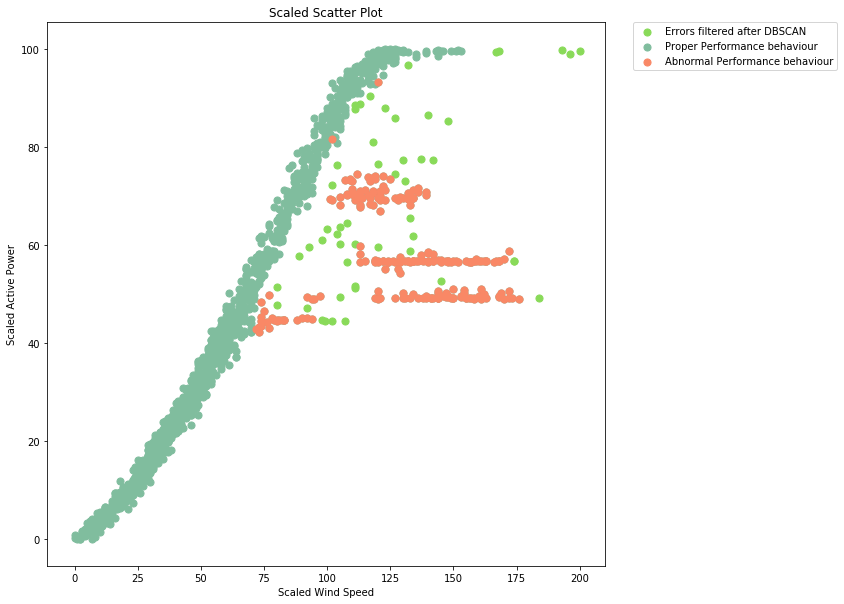

Abnormal Performance Points in WindSpeed vs ActivePower graph.
Arguments default to Mokal


{'abnormalPerformancePoints':                Timestamp  WindSpeed  ActivePower  TurbineState  WindDirection  \
 0    2017-06-14T17:20:00   9.603018   974.474531          11.0      -2.935750   
 1    2017-06-14T16:10:00   9.682672   959.945861          11.0       4.918900   
 2    2017-06-14T17:50:00   9.676424   983.381842          11.0      -0.714700   
 3    2017-06-14T17:40:00   9.762369   986.243288          11.0      -3.119167   
 4    2017-06-14T20:50:00   9.753128  1006.085743          11.0      -2.718450   
 5    2017-06-14T20:40:00   9.776911  1021.403757          11.0     -10.242950   
 6    2017-06-10T06:40:00   9.785581  1086.219283          11.0      -2.968883   
 7    2017-06-14T12:30:00   9.848902  1047.409731          11.0       1.090933   
 8    2017-06-14T21:10:00   9.895011  1001.848202          11.0      -2.705467   
 9    2017-06-14T18:10:00   9.999967   979.433429          11.0      -1.581350   
 10   2017-06-10T06:00:00   9.962841  1113.557057          11.0      

In [18]:
## import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import os

def rounding(mult=1, div=2):
    return lambda x: int((x * mult) / div)


def main(
    filePath,
    turbineStateFilter=11,
    roundingMult=2,
    roundingDiv=1,
    dbscanErrorEps=2,
    dbscanErrorMinSamples=4,
    yMinFilter=107,
    dbscanDegradeEps=4,
    dbscanDegradeMinSamples=0,
    dummyInputXMin=13,
    scaledActivePowerStdLimit=4,
    grpSizeLimit=5,
    plotGraph=False
):

    try:

        abnormalPerfGrpList = []
        dataSet = pd.read_csv(filePath)
        duplicatedPoints = dataSet[dataSet.duplicated(subset=['WindSpeed', 'ActivePower', 'RotorSpeed', 'WindDirection'], keep='first')].reset_index()
        dataSet = dataSet.drop_duplicates(subset=['WindSpeed', 'ActivePower', 'RotorSpeed', 'WindDirection'], keep='first')

        # Filter values
        dataSet = dataSet[
            (dataSet['WindSpeed'] > 0)
            & (dataSet['TurbineState'] == turbineStateFilter)
            & (dataSet['ActivePower'] > yMinFilter)
        ]

        # Normalize Values
        minActivePower = dataSet['ActivePower'].min()
        maxActivePower = dataSet['ActivePower'].max()
        minWindSpeed = dataSet['WindSpeed'].min()
        maxWindSpeed = dataSet['WindSpeed'].max()

        dataSet['scaledActivePower'] = (dataSet['ActivePower'] - minActivePower) * 100 / (maxActivePower - minActivePower)
        dataSet['scaledWindSpeed'] = (dataSet['WindSpeed'] - minWindSpeed) * 100 / (maxWindSpeed - minWindSpeed)
        
        # Cluster for errors
        dataSet['dbscanLabel'] = DBSCAN(eps=dbscanErrorEps, min_samples=dbscanErrorMinSamples).fit_predict(dataSet[['scaledWindSpeed', 'scaledActivePower']])

        # Discritize
        dataSet['discreteWindSpeed'] = dataSet['scaledWindSpeed'].apply(rounding(roundingMult, roundingDiv))

        # Additional Filtering
        filteredErrorsDbscan = dataSet[(dataSet['dbscanLabel'] == -1)].reset_index()
        dataSet = dataSet[
            (dataSet['dbscanLabel'] != -1)
        ]

        # Check Performance
        performanceDropScore = 0
        dropInstances = 0
        performanceDropList = []
        activePowerStdScore = 0
        activePowerStdInstances = 0

        dummyRow = dataSet.loc[dataSet['scaledActivePower'].idxmax()].copy()
        dummyRow['Timestamp'] = '00-00-00T00:00:00'

        dbscanDegradeAlg = DBSCAN(eps=dbscanDegradeEps, min_samples=dbscanDegradeMinSamples)

        for grp in dataSet.groupby('discreteWindSpeed'):
            workGrp = grp[1].reset_index().copy()
            
            # Append Dummy Data
            dummyInputScaledXMin = rounding(roundingMult, roundingDiv)((dummyInputXMin - minWindSpeed) * 100 / (maxWindSpeed - minWindSpeed))
            
            if grp[0] > dummyInputScaledXMin:
                dummyRow['discreteWindSpeed'] = grp[0]
                dummyRow['scaledWindSpeed'] = grp[0]
                workGrp = workGrp.append(dummyRow).append(dummyRow)

            workGrp = workGrp.sort_values('scaledActivePower')
            workGrp['shiftedDown'] = workGrp.scaledActivePower.shift(1)
            grpSize = workGrp.shape[0]
            scaledActivePowerStd = np.std(workGrp['scaledActivePower'])
            if scaledActivePowerStd > scaledActivePowerStdLimit:
                workGrp['degradingPointsLabel'] = dbscanDegradeAlg.fit_predict(workGrp[['discreteWindSpeed' ,'scaledActivePower']])
                for _grp in workGrp.groupby('degradingPointsLabel'):
                    if ((_grp[0] == workGrp.iloc[-2]['degradingPointsLabel']) or
                           (_grp[0] == workGrp.iloc[-1]['degradingPointsLabel'])):
                        continue

                    abnormalPerfGrpList.append(_grp[1])

            activePowerStdScore = activePowerStdScore + scaledActivePowerStd
            activePowerStdInstances = activePowerStdInstances + 1

            if grpSize < grpSizeLimit:
                continue
            spaceSeries = list(workGrp['scaledActivePower'] - workGrp['shiftedDown'])[1:]
            performanceDropScore = performanceDropScore + np.max(spaceSeries)
            performanceDropList.append(np.max(spaceSeries))
            dropInstances = dropInstances + 1

        if len(abnormalPerfGrpList) != 0:
            abnormalPerfDataSet = pd.concat(abnormalPerfGrpList).reset_index()
        else:
            abnormalPerfDataSet = dataSet[[False] * dataSet.shape[0]]

        if plotGraph:
            plt.figure(figsize=(10, 10))
            plt.title('Scaled Scatter Plot')
            plt.xlabel('Scaled Wind Speed')
            plt.ylabel('Scaled Active Power')
            plt.scatter(filteredErrorsDbscan['discreteWindSpeed'], filteredErrorsDbscan['scaledActivePower'], s=np.pi*4*4, c='#89da59', label='Errors filtered after DBSCAN')
            plt.scatter(dataSet['discreteWindSpeed'], dataSet['scaledActivePower'], s=np.pi*4*4, c='#80bd9e', label='Proper Performance behaviour')
            plt.scatter(abnormalPerfDataSet['discreteWindSpeed'], abnormalPerfDataSet['scaledActivePower'], s=np.pi*4*4, c='#f98866', label='Abnormal Performance behaviour')
            plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
            plt.show()            
    
    except Exception as e:
        return {
            'error': e
        }

    
    print 'Abnormal Performance Points in WindSpeed vs ActivePower graph.'
    print 'Arguments default to Mokal'
    
    return {
        'performanceDropScore': performanceDropScore,
        'dropInstances': dropInstances,
        'activePowerStdScore': activePowerStdScore,
        'activePowerStdInstances': activePowerStdInstances,
        'filePath': filePath,
        'abnormalPerformancePoints': abnormalPerfDataSet[['Timestamp', 'WindSpeed', 'ActivePower', 'TurbineState', 'WindDirection', 'RotorSpeed']],
        'filteredErrorPointsDbscan': filteredErrorsDbscan[['Timestamp', 'WindSpeed', 'ActivePower', 'TurbineState', 'WindDirection', 'RotorSpeed']],
        'duplicatedPoints': duplicatedPoints
    }

main('./WSvsAP/ScatterData_Mokal_MK165.csv', plotGraph=True)